# Image processing notebook: From overlap corrected to transmission 

### 00 - Introduction
This notebook demonstrates the use of Jupyter for a Time-of-Flight image processing task. The data corresponds to ToF neutron imaging of coin cells filled with different organic compounds and electrolytes.

*Note: This notebook was written and tested on Windows 10. Running on Mac or Linux machines may need adjustments, e.g. in the path specificationsApplied processing*

### Applied processing
The following processing parts from the averaged pulses, which were already overlap corrected:

- filtering
- Pulse averaging and separtion per experiments
- identification and weighting of OBs for each experiment
- scrubbing correction
- intensity correction
- transmission image generation


### Important Considerations
This notebook starts from the point **after** the overlap correction presented in the image below. This step before (done in a separate notebook) format its destionation directory to be taken by this notebook to process the images correctly.

Transmission Image:

\begin{equation}
T_{img} \rightarrow \frac{I}{I_{0}}=\frac{\frac{\bar{Img}}{OB_{weight}} - SBKG_{img}}{\frac{\bar{Ref}}{OB_{weight}} - SBKG_{ref}}
\end{equation}

## 01 Initial settings
Import all the required libraries

In [1]:
import sys
sys.path.append(r'..\framework')
sys.path.append(r'..\proc_functions')
from stack_proc_func import *
from img_utils_mod import *
import scipy.signal as sp
%matplotlib inline

### Select directories
Select the source directory. This directory is where the images **after** the overlap correction were saved.
Select the destination directory. Here is where the transmission images are going to be saved.

In [2]:
# %load select_directory('src_dir')
src_dir = r"E:\External_Tony\Processed\exp2XX\00_overlap_corrected"

In [3]:
# %load select_directory('dst_dir')
dst_dir = r"E:\External_Tony\Processed\exp2XX\test_reg_transmission"

### Select working folders
Once the directories are loaded, you can start to do a selection of the folders you want to process. <br>
The next function loads the folders availableas a visual aid. However, you can avoid this step just by looking at the source folder in the windows explorer.

In [4]:
all_folders = prep_stack_dict(src_dir)
for key in all_folders.keys():
    print(key)

00_ob_ini
01_so_ref
02_exp201_00
02_exp201_01
02_exp201_02
02_exp201_03
02_exp201_04
02_exp201_05
02_exp201_06
02_exp201_07
02_exp201_08
02_exp201_09
02_exp201_10
02_exp201_11
02_exp201_12
02_exp201_13
02_exp201_14
02_exp201_15
02_exp201_16
02_exp201_17
03_ob_end


For this test we will select some folders that we want to process as '`proc_folder`' and our reference as '`ref_folder`'.

* _note: `proc-folder` can take several strings as value, for that reason is a list of strings. On the other hand, `ref_folder` is always one, for that reason it is just a string._

In [5]:
proc_folder01 = ["02_exp201_00","02_exp201_01"]
proc_folder02 = ["02_exp201_02","02_exp201_03"]
proc_folder03 = ["02_exp201_04","02_exp201_05"]
proc_folder04 = ["02_exp201_06","02_exp201_07"]
proc_folder05 = ["02_exp201_08","02_exp201_09"]
proc_folder06 = ["02_exp201_10","02_exp201_11"]
proc_folder07 = ["02_exp201_12","02_exp201_13"]
proc_folder08 = ["02_exp201_14","02_exp201_15"]
proc_folder09 = ["02_exp201_16","02_exp201_17"]

ref_folder = '01_so_ref'

## 02 Filtering process definition
Here we define the process that each image will have before the pulse averaging (if any).

* _note: The sequence generated must contain the names of each function and at the end the 'stack_avg' function which performs the pulse averaging. <br> i.e.  test_seq = [`function_1`, `function_2`, `more functions`, `stack_avg`]_

### White spots filtering
The white spots are removed by applying a median filter of size 'ws_filter_size'

In [6]:
from skimage.filters import gaussian, median, meijering
from skimage.morphology import disk

def ws_filter(src_img, ws_filter_size, **kwargs):
    return sp.medfilt2d(src_img.astype('float32'), ws_filter_size)

def gaussian_filter(x, sigma,**kwargs):
    return gaussian(x, sigma)

def outlier_removal (img, threshold, **kwargs):
    mask_x = np.where(img <= threshold)[0]
    mask_y = np.where(img <= threshold)[1]
    for x, y in zip(mask_x, mask_y) :
        slice = img[max(0, x-1):x+1, max(0,y-1):y+1] # assuming you want 5x5 square
        img[x,y] = np.mean([i for i in slice.flatten() if i > threshold])  # threshold is 0
    return img

def median_filter(x, **kwargs):
    return median(x)
def remove_nan (img, **kwargs):
    return np.nan_to_num(img)

In [7]:
roi_crop = [29, 333, 419, 130]

In [8]:
test_seq = [crop_img, outlier_removal, stack_avg]

## 03 Filter testing
The `test_filter_stack` function test the filters given in the `test_seq` list and prints the image.<br> A selection of a testing folder named `test_folder` is required to proceed with the image checkout. <br> 
-If no specific image is selected, it automatically selects the image at the median point in the stack.<br>

* _note: if the filtering functions inserted in the `test_seq` require aditional arguments or variables, they can be given as `**kwargs` inside the function parameters. i.e `ws_filter_size = 5` was given in the function for the ws_filter usage._

threshold = 0
roi_crop = [29, 333, 419, 130]


Averaging: 100%|███████████████████████████████| 20/20 [00:00<00:00, 41.17it/s]


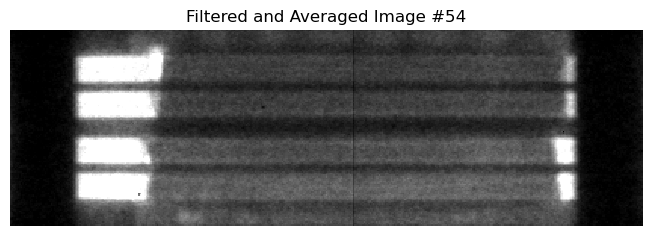

In [9]:
test_folder = '02_exp201_09'
img = test_filtering_stack (src_dir,dst_dir, test_folder = test_folder, 
                            test_seq = test_seq, give_data=True, threshold=0, roi_crop = roi_crop)


### Confirm the operations sequence
After you are satisfied with the result, write the real sequence `seq` that will be used for all the images.

In [10]:
seq = [crop_img, outlier_removal]

## 04 Selecting ROIS and other variables
Each campaign is different, if there are some requirements that the processing require, you can insert them as `**kwargs`. <br>
In the case of this specific campaing (PSI19_03NI), the MCP detector did not adquire correctly the first 9 images in each process. For that reason, the processing needs to remove those images. Thus, we can slice the folder by givin the values that we want with `start_slice` and `end_slice`. 

* _note: If we want to slice the starting but not the end, it is just required to give the beginning (`start_slice`) and leave `end_slice` blank as in the next example._

### ROI selection (program still needs the implementation of the CSV option)
One important parameter are the ROIs, specifically the non-changing-area (nca). Fo that reason, we do a use an interactive command to select them.

If more ROIs were selected (other than the first -nca-), these will be used to create a CSV file at the end with the all the transmission values included. <br>**waiting for implementation in stack_batch_proc**

The window for ROI selection still open in a separate window, I am checking the way to have it printed in the notebook to avoid changing any mistake 

* _note: the option 'flip_image = True' is required to agree with imageJ format of showing the image. In stack_batch_proc it is implemented in the intensity correction part (TFC_corr). The modifications done to img_utils _

**to select several ROIs: for each ROI selected, press ENTER, when finish, press ESC**

In [11]:
# %load select_rois(img, list_rois = ['nca'])
nca = [49, 43, 41, 13]

To agree with the selected ROIs, the image is shown with its labeling, being label 1 the first ROI selected i.e nca, second label 2 and so forth

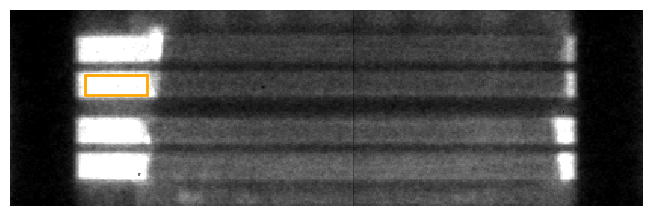

In [12]:
show_img(img, dr = [nca])

## 05 BB mask
The BB mask is a fits image saved in the source directory. if all the experiments are aligned, one BB mask can be used. However, if there are misalignments, several BB masks must be given. 

**a program that creates the BB mask for that specific experiment would be extremly useful in this case so we do not need to care anymore about BBs**

For the moment being and as an example, the program takes a real (for testing) BB mask to include it in the process

In [17]:
ref_mask_img = get_img(src_dir + '/bb_mask.fits')
img_mask_img = get_img(src_dir + '/bb_mask.fits')
reg_img = get_img(src_dir + '/reg_img2.fits')

## 06 Run first transmission image test 
This will give you one transmission image as an example of the whole process.

Set a starting and ending slice (to speed up the process, do not choose more tan 10 images or do it in different parts of the spectrum)

In [18]:
stack_test = stack_batch_proc (src_dir, dst_dir, ref_mask_img,img_mask_img, reg_img, proc_folder = [test_folder], 
         ref_folder = ref_folder, avg_seq = seq, save_results = False, start_slice = 30, end_slice = 40, 
         print_TFC = True, nca=nca, threshold = 0, roi_crop =roi_crop, stack_avg=False, scrubbing=True, 
        HE_LE = ([3,23],[60,80]))

start_slice = 30
end_slice = 40
print_TFC = True
nca = [49, 43, 41, 13]
threshold = 0
roi_crop = [29, 333, 419, 130]
stack_avg = False


Processing: 100%|████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


Performing Image Registration
entered to perform scrubbing


Processing: 100%|████████████████████████████████| 2/2 [00:00<00:00, 20.13it/s]

02_exp201_09
ref folder processing: folder_00
area cropped (img) = 0.08242563082495888
area cropped (ref) = 0.38430285956567084
area cropped (img) = 0.00011141017434392904
area cropped (ref) = 0.3831746734175983
ref folder processing: folder_01
area cropped (img) = 0.055844330691658936
area cropped (ref) = 0.38430285956567084
area cropped (img) = 0.00011141017434392904
area cropped (ref) = 0.3831746734175983
ref folder processing: folder_02
area cropped (img) = 0.06469569859882127
area cropped (ref) = 0.38430285956567084
area cropped (img) = 0.00011141017434392904
area cropped (ref) = 0.3831746734175983
ref folder processing: folder_03
area cropped (img) = 0.07286678821083234
area cropped (ref) = 0.38430285956567084
area cropped (img) = 0.00011141017434392904
area cropped (ref) = 0.3831746734175983
ref folder processing: folder_04
area cropped (img) = 0.07972537381968925
area cropped (ref) = 0.38430285956567084
area cropped (img) = 0.00011141017434392904
area cropped (ref) = 0.38317467

### Testing the NCA region 

This region is characterized for having a value of 1. The process might have an error if this region has values greater that 0.05% of the theoretical one.

In [19]:
nca_reg =[]
for key, val in stack_test.items():
    print(key)
    for key2, im in val.items():
        print(key2)
        for arr in im:
            nca_reg.append(np.mean(roi_in_image(arr[0],nca)))
        print('value cropped reg {}'.format(np.mean(nca_reg)))
        print(nca_reg)
print(len(nca_reg))
print('Average value in the NCA is {}'.format(np.mean(nca_reg)))

02_exp201_09
folder_00
value cropped reg 0.9955280542592544
[1.0027007313079779, 0.988355377210531]
folder_01
value cropped reg 0.9956960050433247
[1.0027007313079779, 0.988355377210531, 1.0033725344442588, 0.988355377210531]
folder_02
value cropped reg 0.9954798974817235
[1.0027007313079779, 0.988355377210531, 1.0033725344442588, 0.988355377210531, 1.0017399875065114, 0.988355377210531]
folder_03
value cropped reg 0.9954573431396592
[1.0027007313079779, 0.988355377210531, 1.0033725344442588, 0.988355377210531, 1.0017399875065114, 0.988355377210531, 1.0024239830164012, 0.988355377210531]
folder_04
value cropped reg 0.9955016759366165
[1.0027007313079779, 0.988355377210531, 1.0033725344442588, 0.988355377210531, 1.0017399875065114, 0.988355377210531, 1.0024239830164012, 0.988355377210531, 1.0030026370383602, 0.988355377210531]
folder_05
value cropped reg 0.9955819439446026
[1.0027007313079779, 0.988355377210531, 1.0033725344442588, 0.988355377210531, 1.0017399875065114, 0.98835537721053

## 07 Full image processing
After all tests are correct, you can process and do the full image process for all the folders that you want with the captured parameters.

The result of using the next function is that all the transmission images generated with it are saved with a .fits extension in your destination folder and HE and LE sections will be saved in another 2 folders.

__Note:__ If you are sure fo the process, you can leave `proc_folder` empty `proc_folder = []`,the program will process all folders included in the source directory.

In [20]:
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, reg_img, proc_folder = proc_folder01, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, threshold = 0, roi_crop =roi_crop, 
                  stack_avg=False, scrubbing=True,HE_LE = ([8,23],[70,85]))

nca = [49, 43, 41, 13]
threshold = 0
roi_crop = [29, 333, 419, 130]
stack_avg = False


Processing: 100%|████████████████████████████████| 6/6 [00:16<00:00,  2.80s/it]


Performing Image Registration


IndexError: index -2147483648 is out of bounds for axis 0 with size 419

In [ ]:
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, proc_folder = proc_folder02, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, ws_filter_size = 3, roi_crop =roi_crop, 
                  stack_avg=False, scrubbing=True,HE_LE = ([8,23],[70,85]))

In [ ]:
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, proc_folder = proc_folder03, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, ws_filter_size = 3, roi_crop =roi_crop, 
                  stack_avg=False, scrubbing=True,HE_LE = ([8,23],[70,85]))

In [ ]:
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, proc_folder = proc_folder04, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, ws_filter_size = 3, roi_crop =roi_crop, 
                  stack_avg=False, scrubbing=True,HE_LE = ([8,23],[70,85]))

In [ ]:
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, proc_folder = proc_folder05, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, ws_filter_size = 3, roi_crop =roi_crop, 
                  stack_avg=False, scrubbing=True,HE_LE = ([8,23],[70,85]))

In [ ]:
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, proc_folder = proc_folder06, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, ws_filter_size = 3, roi_crop =roi_crop, 
                  stack_avg=False, scrubbing=True,HE_LE = ([8,23],[70,85]))

In [ ]:
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, proc_folder = proc_folder07, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, ws_filter_size = 3, roi_crop =roi_crop, 
                  stack_avg=False, scrubbing=True,HE_LE = ([8,23],[70,85]))

In [ ]:
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, proc_folder = proc_folder08, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, ws_filter_size = 3, roi_crop =roi_crop, 
                  stack_avg=False, scrubbing=True,HE_LE = ([8,23],[70,85]))

In [ ]:
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, proc_folder = proc_folder09, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, ws_filter_size = 3, roi_crop =roi_crop, 
                  stack_avg=False, scrubbing=True,HE_LE = ([8,23],[70,85]))